# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=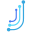)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

### Imputar consiste en estimar los valores ausentes con base en los valores válidos de otras variables y/o casos de muestra. 

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [2]:
%run pandas-missing-extension.ipynb

/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/upsetplot/plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


## Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [4]:
airquality_df=(
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type = 'snake'
    )
    .add_column(
        'year',1973
    )
    .assign(
        date= lambda df: pd.to_datetime(df[['year','month','day']])
    )
    .sort_values(by='date')
    .set_index('date')
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula = 'temp ~ ozone',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Fri, 16 Jun 2023",Prob (F-statistic):,2.93e-18
Time:,07:34:20,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula = 'temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Fri, 16 Jun 2023",Prob (F-statistic):,1.47e-16
Time:,07:34:21,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [7]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [8]:
(
    smf.ols(
        formula= 'death ~ creatinine + age + futime + kappa + C(chapter)',
        data= survival_df
    )
    .fit()
    .summary()
)

/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -102.2
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               1.00
Time:                        07:34:24   Log-Likelihood:                 59833.
No. Observations:                1962   AIC:                        -1.196e+05
Df Residuals:                    1942   BIC:                        -1.195e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              1.0000   7.48e-15   1.34e+14      0.000       1.000       1.000
C(chapter)[T.Circulatory]          -6.262e-16   6.95e-15     -0.090      0.928   -1.43e-14     1.3e-14
C(chapter)[T.Congenital]           -1.874e-15   1.07e-14     -0.174      0.862   -2.29e-14    1.92e-14
C(chapter)[T.Digestive]            -2.526e-16   7.16e-15     -0.035      0.972   -1.43e-14    1.38e-14
C(chapter)[T.Endocrine]            -1.003e-15   7.26e-15     -0.138      0.890   -1.52e-14    1.32e-14
C(chapter)[T.External Causes]      -4.167e-16   7.17e-15     -0.058      0.954   -1.45e-14    1.36e-14
C(chapter)[T.Genitourinary]         1.328e-15    7.3e-15      0.182      0.856    -1.3e-14    1.56e-14
C(chapter)[T.Ill Defined]          -2.142e-15   7.31e-15     -0.293      0.770   -1.65e-14    1.22e-14
C(chapter)[T.Infectious]           -1.062e-15   7.45e-15     -0.142      0.887   -1.57e-14    1.36e-14
C(chapter)[T.Injury and Poisoning]  1.211e-15   7.61e-15      0.159      0.874   -1.37e-14    1.61e-14
C(chapter)[T.Mental]                 2.34e-15   7.04e-15      0.333      0.740   -1.15e-14    1.61e-14
C(chapter)[T.Musculoskeletal]      -7.691e-16   8.01e-15     -0.096      0.924   -1.65e-14    1.49e-14
C(chapter)[T.Neoplasms]            -2.774e-15   6.97e-15     -0.398      0.691   -1.64e-14    1.09e-14
C(chapter)[T.Nervous]              -4.218e-17   7.05e-15     -0.006      0.995   -1.39e-14    1.38e-14
C(chapter)[T.Respiratory]           5.855e-18      7e-15      0.001      0.999   -1.37e-14    1.37e-14
C(chapter)[T.Skin]                 -4.312e-15   9.81e-15     -0.440      0.660   -2.35e-14    1.49e-14
creatinine                          2.125e-17   6.86e-16      0.031      0.975   -1.32e-15    1.37e-15
age                                -8.592e-18   3.31e-17     -0.259      0.795   -7.36e-17    5.64e-17
futime                             -5.203e-18   2.45e-19    -21.266      0.000   -5.68e-18   -4.72e-18
kappa                              -5.256e-16   3.19e-16     -1.649      0.099   -1.15e-15    9.94e-17
==============================================================================
Omnibus:                      550.876   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.114
Skew:                           0.161   Prob(JB):                     8.16e-22
Kurtosis:                       1.959   Cond. No.                     2.28e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Preparando datos: _National Health and Nutrition Examination Survey_

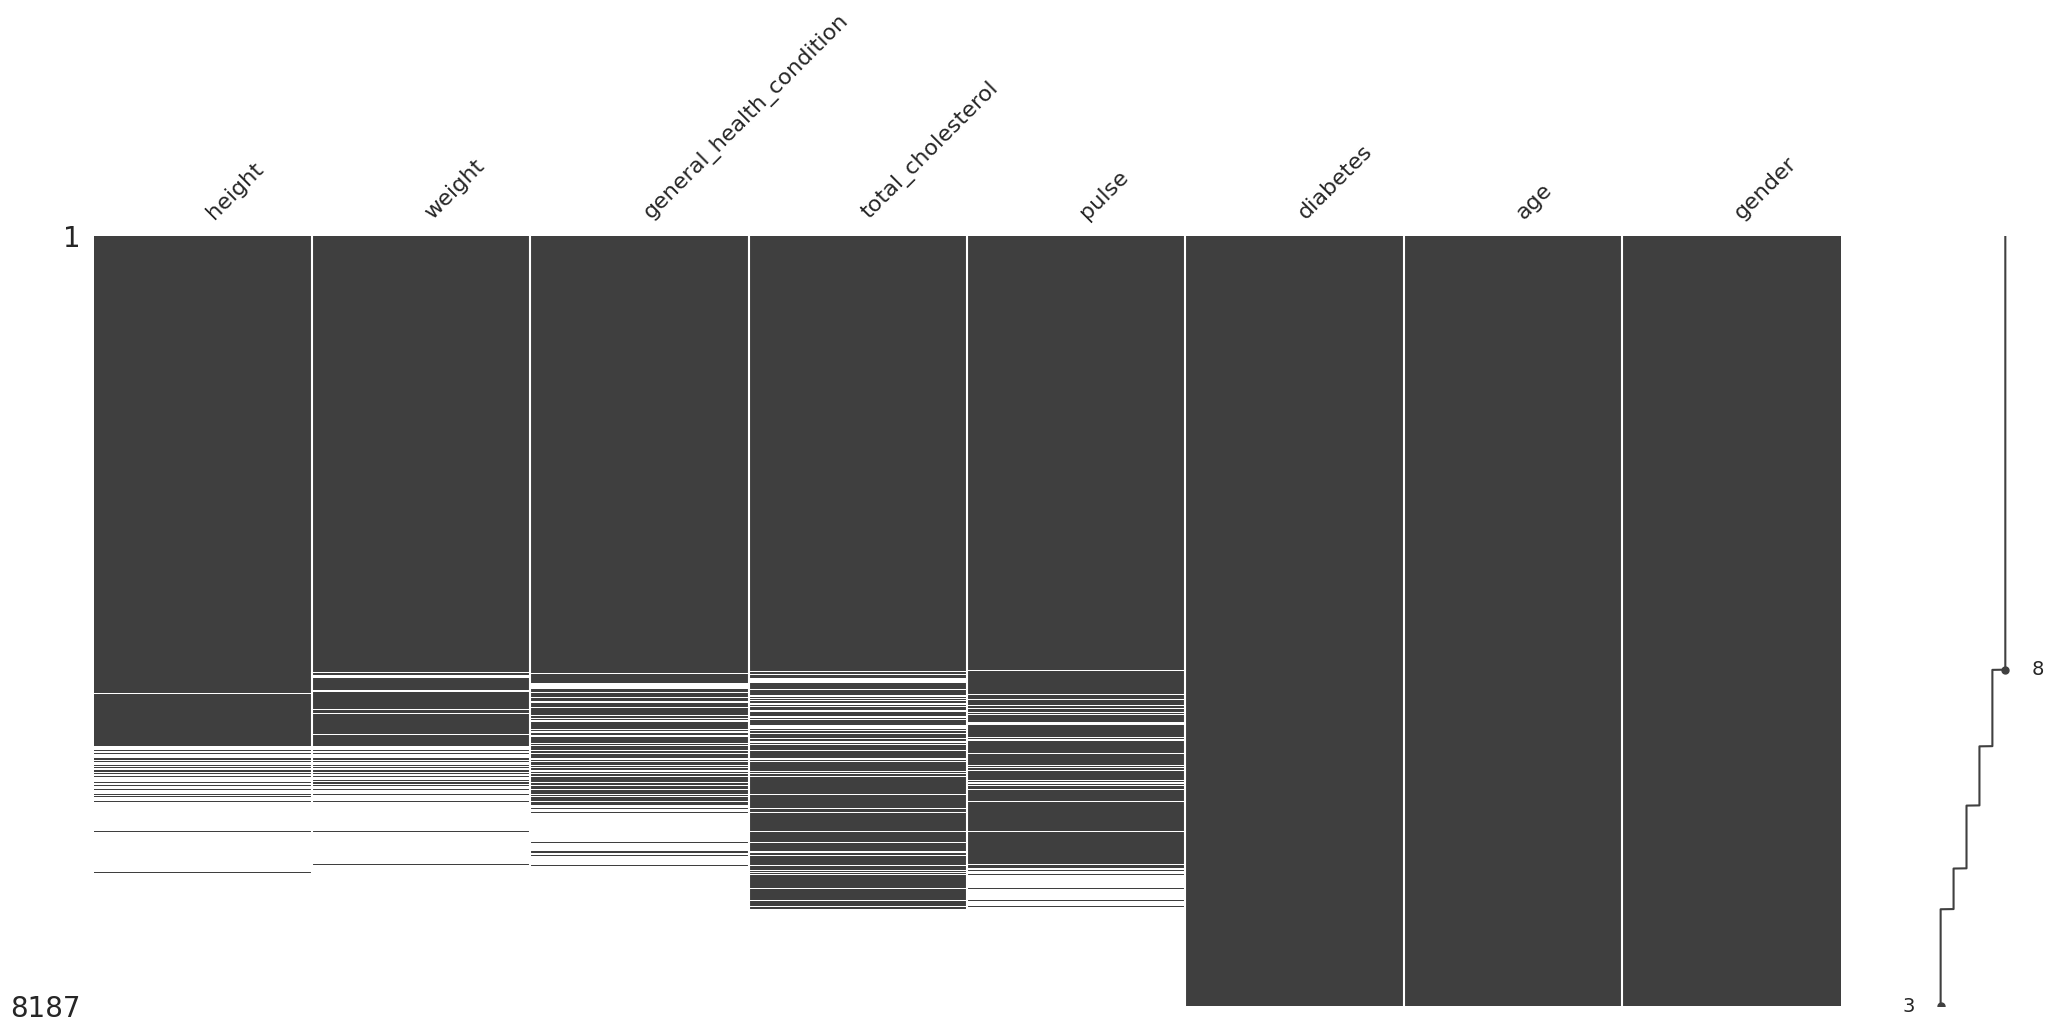

/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


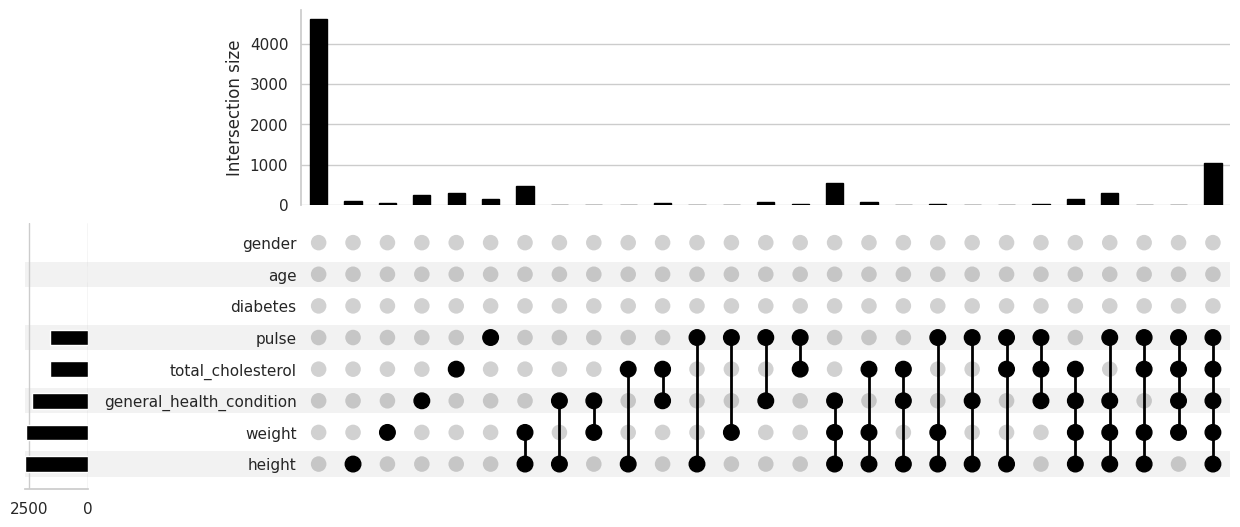

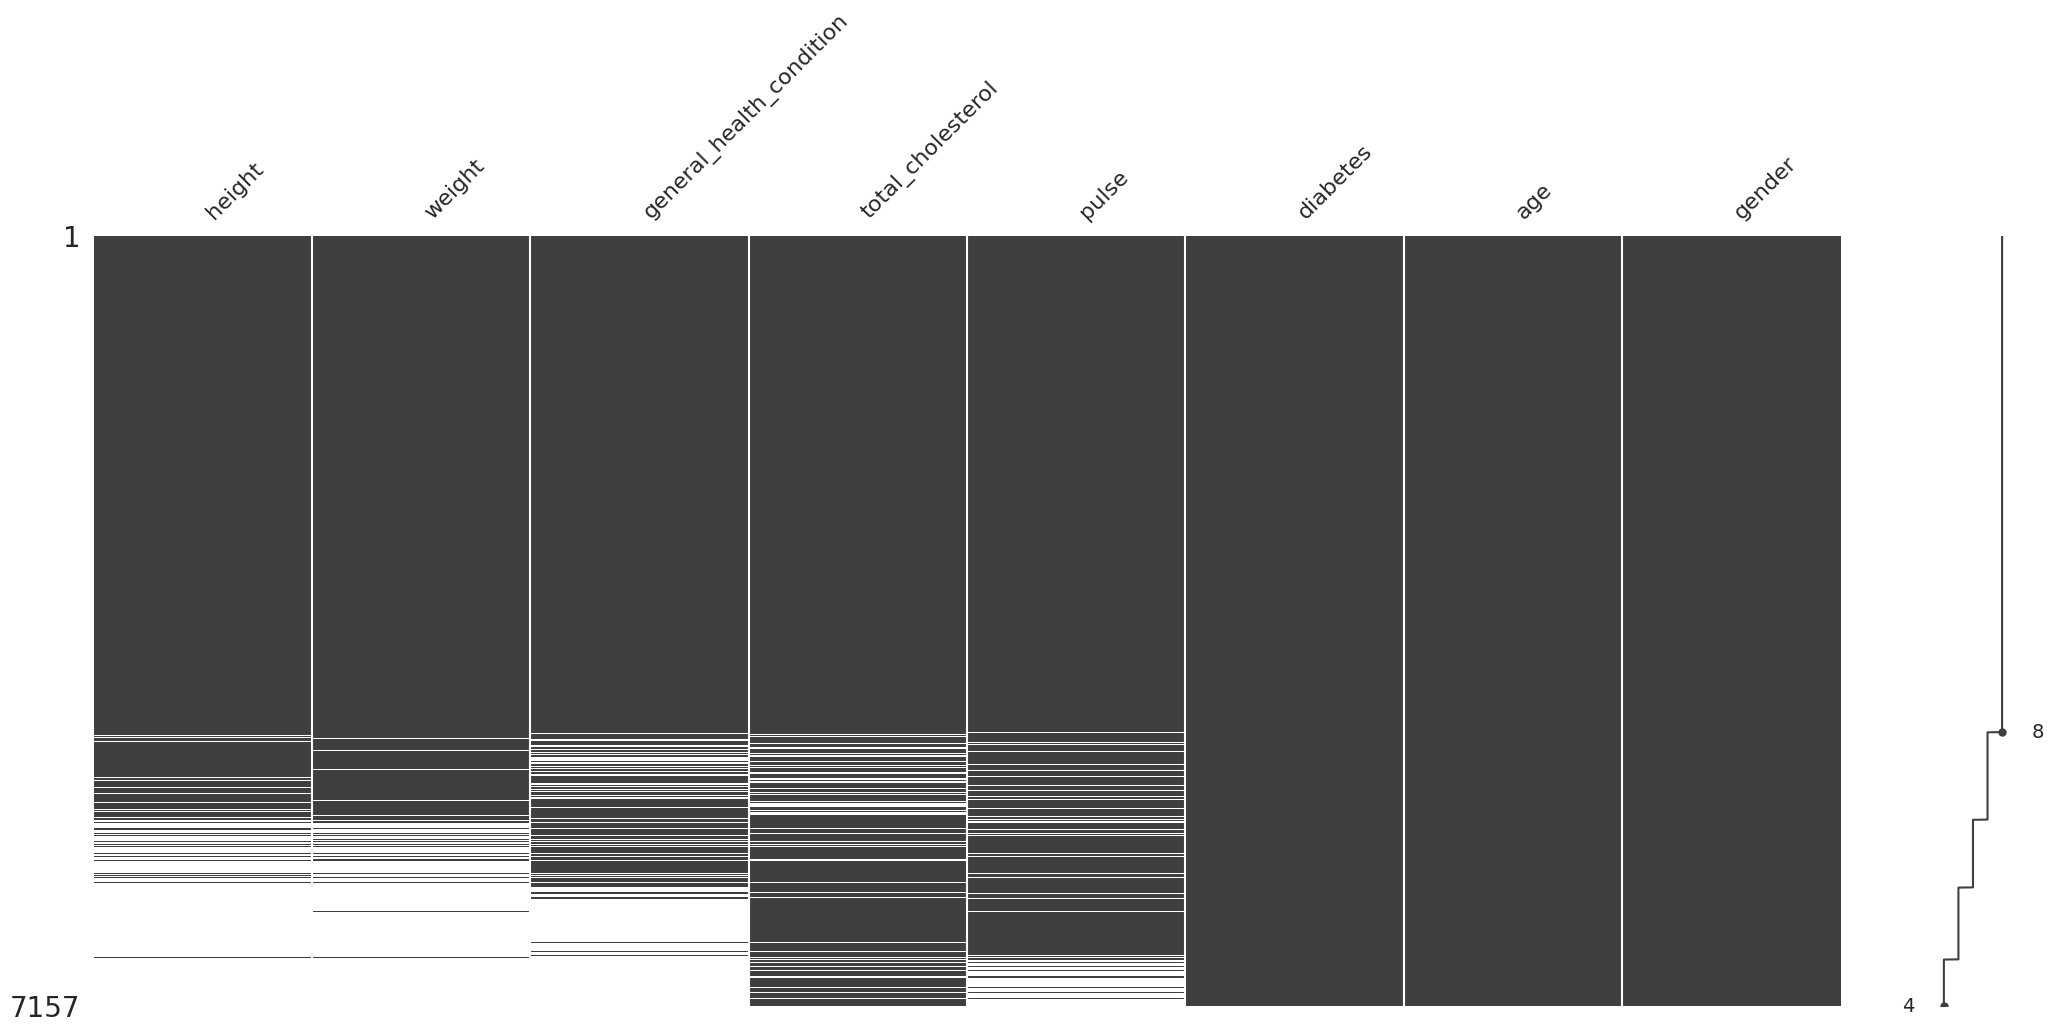

In [9]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

La prueba de t-student nos sirve para verificar si una hipotesis nula puede ser rechazada o no (p_value<0.05), si el valor es mayor, no puede rechazarse.

In [10]:
female_weight,male_weight= (
    nhanes_df
    .select_columns( 
        'weight',
        'gender'
        )
    .transform_columns(
        ['weight'],
        lambda x:x.isna(),
        elementwise= False 
        )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_weight,
    b=male_weight,
    alternative='two-sided'
)


Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

Se puede observar como al realizar un ztest, el cual es más adecuado para muestras mayores a n=30, tiene resultados similiares al ttest

In [11]:
from statsmodels.stats.weightstats import ztest

ztest(female_weight,male_weight,value=0)

(-0.3621032192538131, 0.7172748980457191)

## Amplía tu conjunto de herramientas para explorar valores faltantes

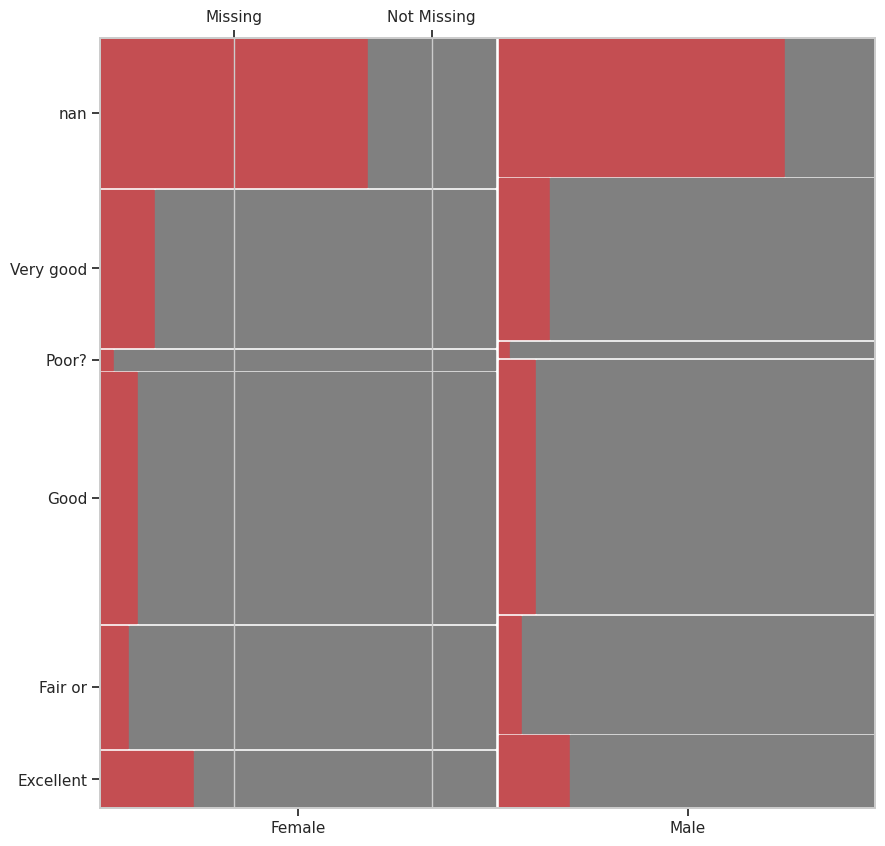

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
(
    nhanes_df
    .select_columns(
        'weight',
        'general_health_condition',
        'gender'
        )
    .assign(
        weight= lambda df:df['weight'].isna()
        .replace(
            [True,False],
            ['Missing','Not Missing']
        )
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties = lambda key : {'color':'r' if 'Missing' in key else 'gray'},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title= '',
            labelizer= lambda key:'',
        )
    )
    
)
ax.grid(False)
plt.show()

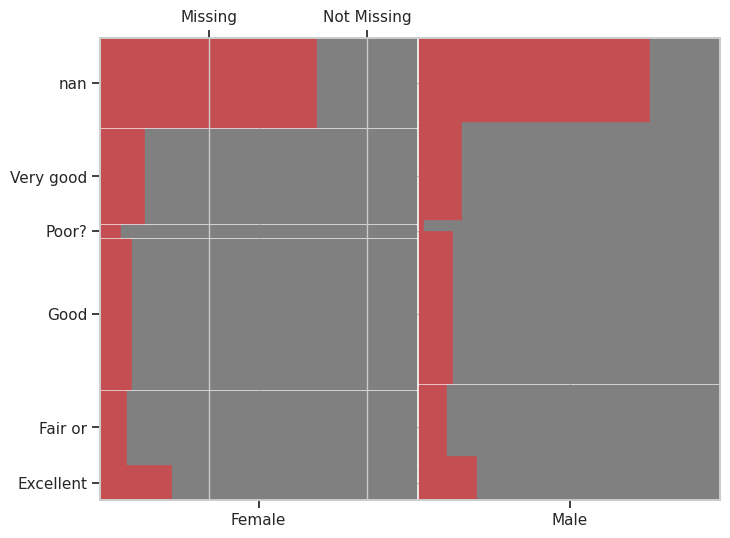

In [13]:
nhanes_df.missing.missing_mosaic_plot(
    target_var='height',
    x_categorical_var = 'gender',
    y_categorical_var = 'general_health_condition'
)
ax.grid(False)
plt.show()

## Tratamiento de variables categóricas para imputación de valores faltantes

In [14]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [15]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [['Male'],['Female'],['Female']]
X

[['Male'], ['Female'], ['Female']]

In [16]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [17]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [18]:
encoder.inverse_transform([[0],[0],[1]])

array([['Female'],
       ['Female'],
       ['Male']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [19]:
categorical_columns= nhanes_df.select_dtypes(object,'category').columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [20]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder= 'passthrough'
)

In [21]:

nhanes_transformed_df= (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
        
        )
    .rename_columns(
        function = lambda x:x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x:x.removeprefix('remainder__')
    )
)

In [22]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = ( 
    nhanes_df
   .gender
   .values
   .reshape(-1, 1)
 )

 
gender_encoder.fit_transform(
    X = gender_values).squeeze()


 
(nhanes_df.gender.unique(),
nhanes_transformed_df.gender.unique(),
gender_encoder.categories_
 )

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])

### _One Hot Encoding_

In [23]:
nhanes_transformed_df2=(nhanes_df.copy(deep=True))

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [24]:
(
    nhanes_transformed_df2
    .select_columns('general_health_condition')
    .pipe(
        pd.get_dummies
    )
    .replace(
        [True,False],
        [1,0]
    )
    .columns
)

Index(['general_health_condition_Excellent',
       'general_health_condition_Fair or', 'general_health_condition_Good',
       'general_health_condition_Poor?', 'general_health_condition_Very good'],
      dtype='object')

#### `skelearn.preprocessing.OneHotEncoder()`

In [25]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),['gender']),
    (sklearn.preprocessing.OneHotEncoder(),['general_health_condition']),
    remainder='passthrough'
    )


In [26]:
nhanes_transformed_df2= (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
        
        )
    .rename_columns(
        function = lambda x:x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x:x.removeprefix('remainder__')
    )
    .rename_columns(
        function = lambda x:x.removeprefix('onehotencoder__')
    )
)

In [27]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [28]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [29]:
(
    nhanes_df
    .transform_columns(
        ['height'],
        lambda x:x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

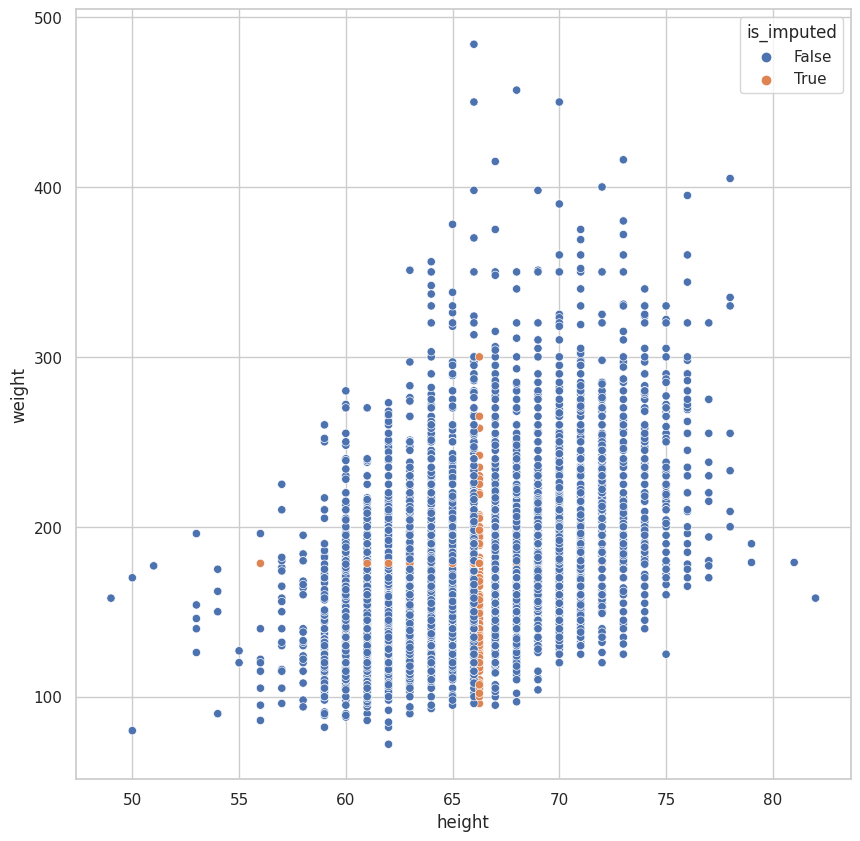

In [30]:
plt.figure(figsize=(10,10))
(
    nhanes_df
    .select_columns(
        'height',
        'weight'
    )
    .missing.bind_shadow_matrix(true_string=True,false_string= False, suffix= '_imp')
    .assign(
         height = lambda df:df.height.fillna(value= df.height.mean()),
        weight = lambda df:df.weight.fillna(value= df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        
    )
 
)
plt.show()

<Figure size 1500x1500 with 0 Axes>

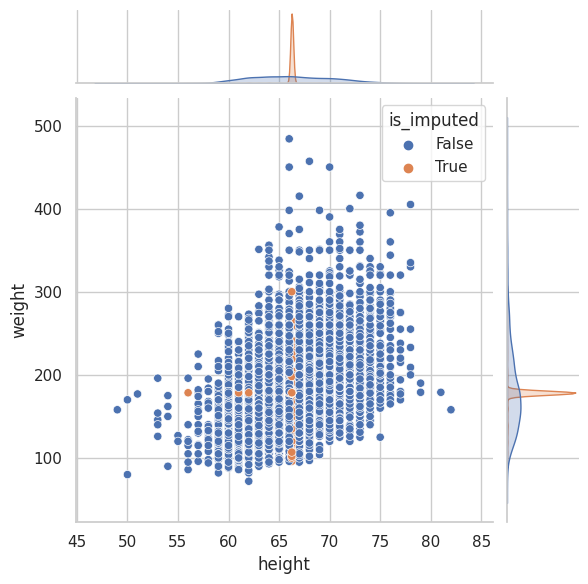

In [31]:
plt.figure(figsize=(15,15))
(
    nhanes_df
    .select_columns(
        'height',
        'weight'
    )
    .missing.bind_shadow_matrix(true_string=True,false_string= False, suffix= '_imp')
    .assign(
         height = lambda df:df.height.fillna(value= df.height.mean()),
        weight = lambda df:df.weight.fillna(value= df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal=True
        
    )
 
)
plt.show()

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

- fillna = Fill na o rellenado de valores nulos
- ffill = Forward fill o rellenado hacia delante
- bfill = Backward fill o rellenado hacia atrás


In [32]:
(
    nhanes_df
    .select_columns(
        ['weight','height']
    )
    #.fillna(method='ffill')
    .ffill()
)

,weight,height
SEQN,,
93705.0,165.0,63.0
93706.0,145.0,68.0
93707.0,145.0,68.0
93709.0,200.0,62.0
93711.0,142.0,69.0
...,...,...
102949.0,180.0,72.0
102953.0,218.0,65.0
102954.0,150.0,66.0


In [33]:
(
    nhanes_df
    .select_columns(
        ['weight','height']
    )
    #.fillna(method='ffill')
    .bfill()
)

,weight,height
SEQN,,
93705.0,165.0,63.0
93706.0,145.0,68.0
93707.0,200.0,62.0
93709.0,200.0,62.0
93711.0,142.0,69.0
...,...,...
102949.0,180.0,72.0
102953.0,218.0,65.0
102954.0,150.0,66.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [34]:
(
    nhanes_df
    .select_columns(
        ['height','weight','gender','diabetes','general_health_condition']
    )
    .sort_values(
        by = ['gender','diabetes','general_health_condition','height'],
        ascending=True
    )
    .transform_column(
        'weight',
        lambda x:x.ffill(),
        elementwise=False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


In [35]:
(
    nhanes_df
    .select_columns(
        ['height','weight','gender','diabetes','general_health_condition']
    )
    .sort_values(
        by = ['gender','diabetes','general_health_condition','height'],
        ascending=True
    )
    .groupby(
        ['gender','general_health_condition'],
        dropna=False
    )
    .apply(
        lambda x:x.ffill()
    )
    
)

height  weight  gender  diabetes  \
gender general_health_condition SEQN                                        
Female Excellent                94421.0    56.0   115.0  Female         0   
                                94187.0    59.0   130.0  Female         0   
                                95289.0    59.0   162.0  Female         0   
                                97967.0    59.0   130.0  Female         0   
                                99125.0    59.0   105.0  Female         0   
...                                         ...     ...     ...       ...   
Male   NaN                      96561.0    74.0   290.0    Male         1   
                                96954.0    74.0   175.0    Male         1   
                                97267.0    74.0   175.0    Male         1   
                                97856.0    74.0   175.0    Male         1   
                                98317.0    74.0   175.0    Male         1   

                                        general_health_condition  
gender general_health_condition SEQN                              
Female Excellent                94421.0                Excellent  
                                94187.0                Excellent  
                                95289.0                Excellent  
                                97967.0                Excellent  
                                99125.0                Excellent  
...                                                          ...  
Male   NaN                      96561.0                      NaN  
                                96954.0                      NaN  
                                97267.0                      NaN  
                                97856.0                      NaN  
                                98317.0                      NaN  

[7157 rows x 5 columns]

## Imputación por interpolación

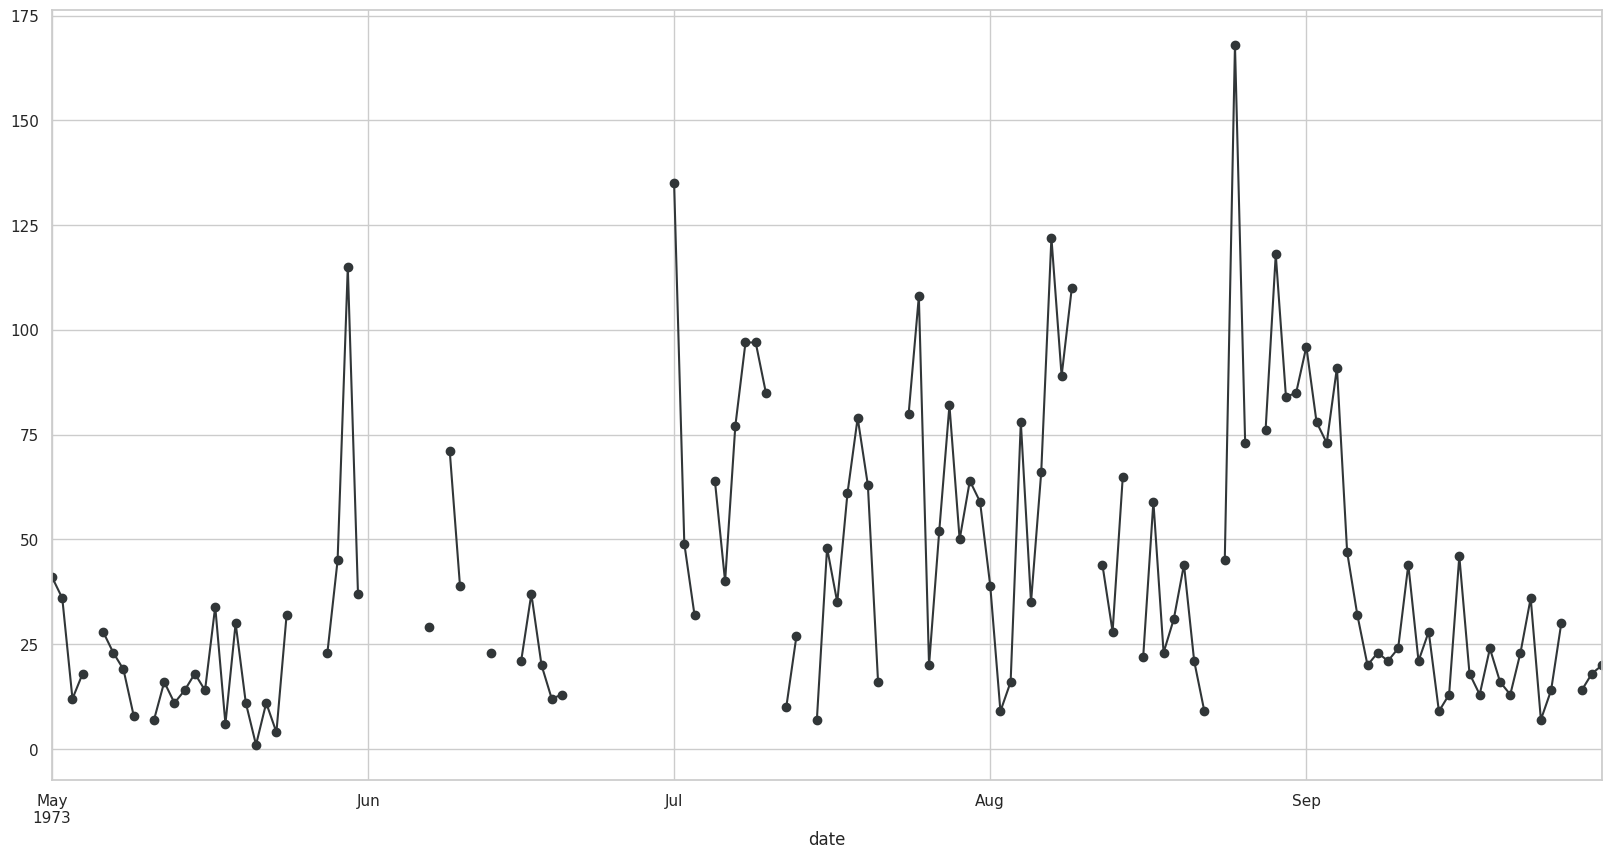

In [36]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

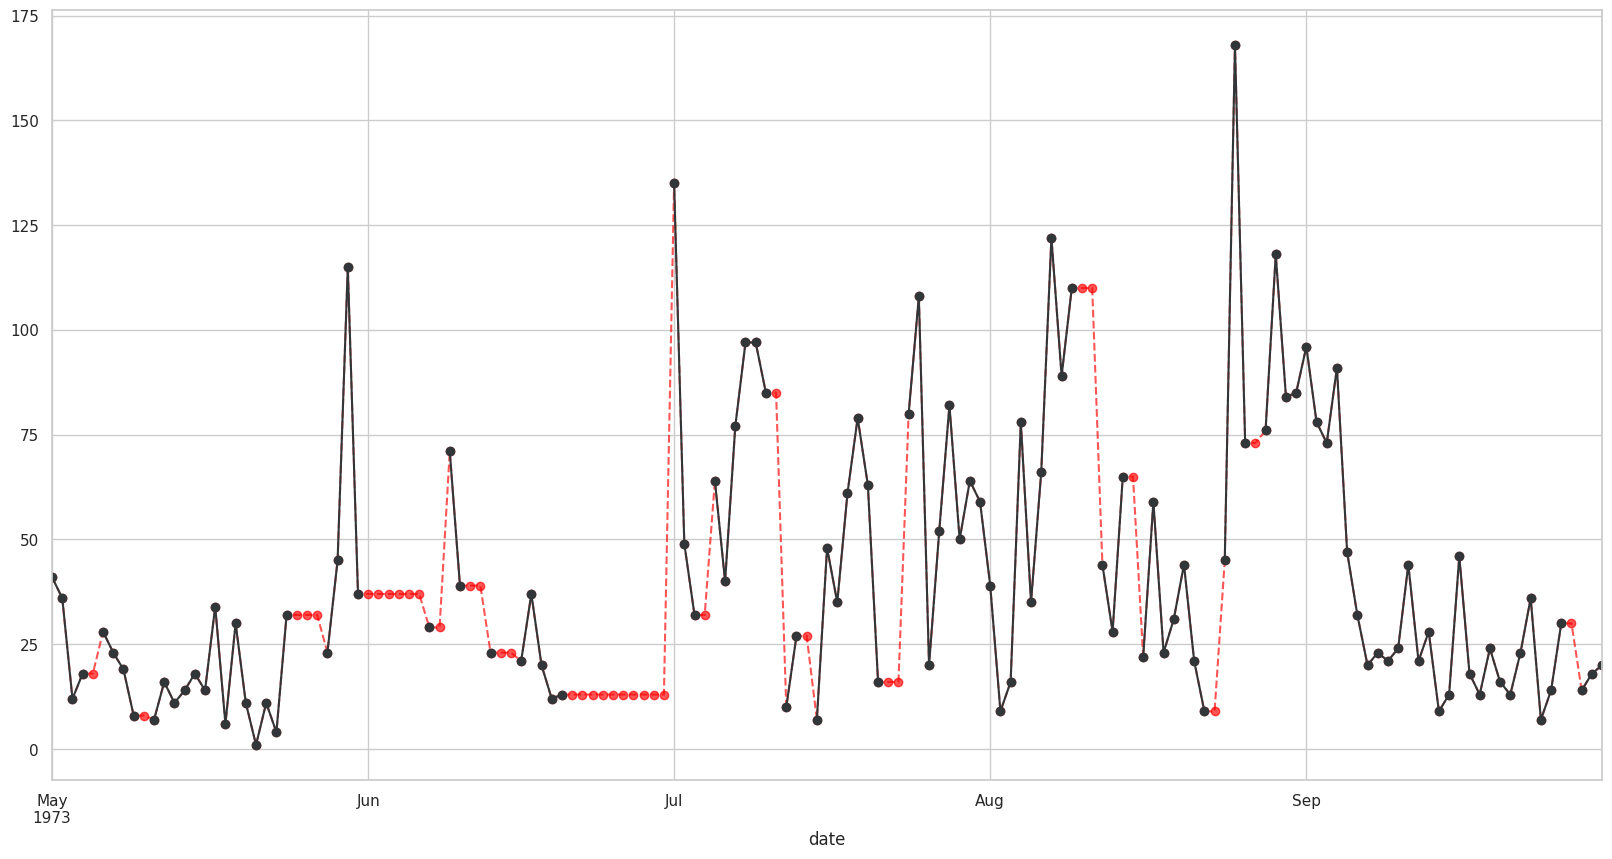

In [37]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.ffill().plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

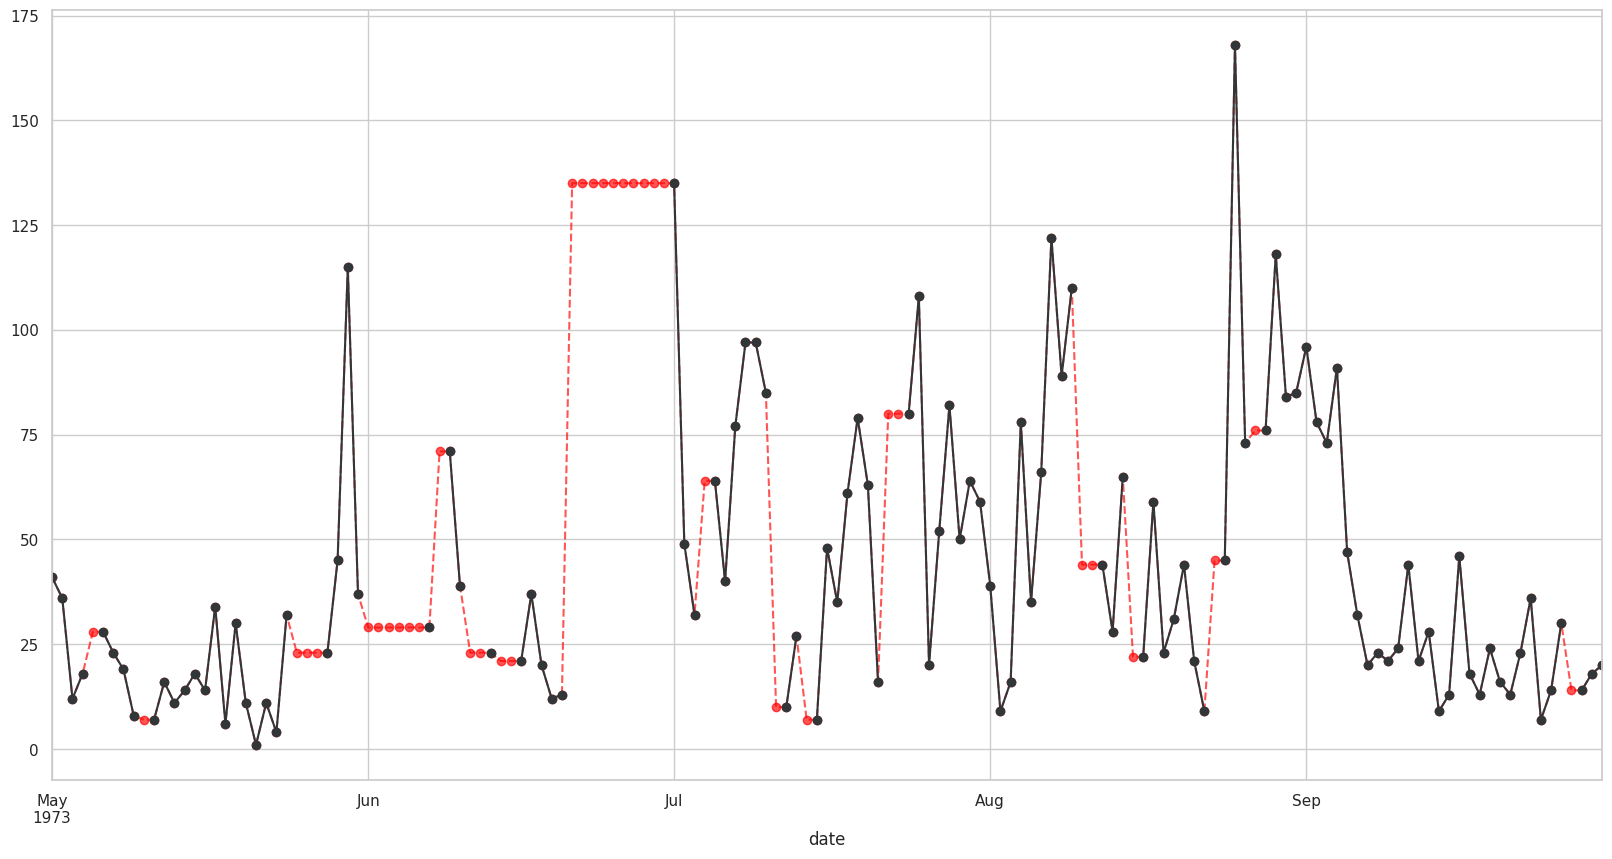

In [38]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.bfill().plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

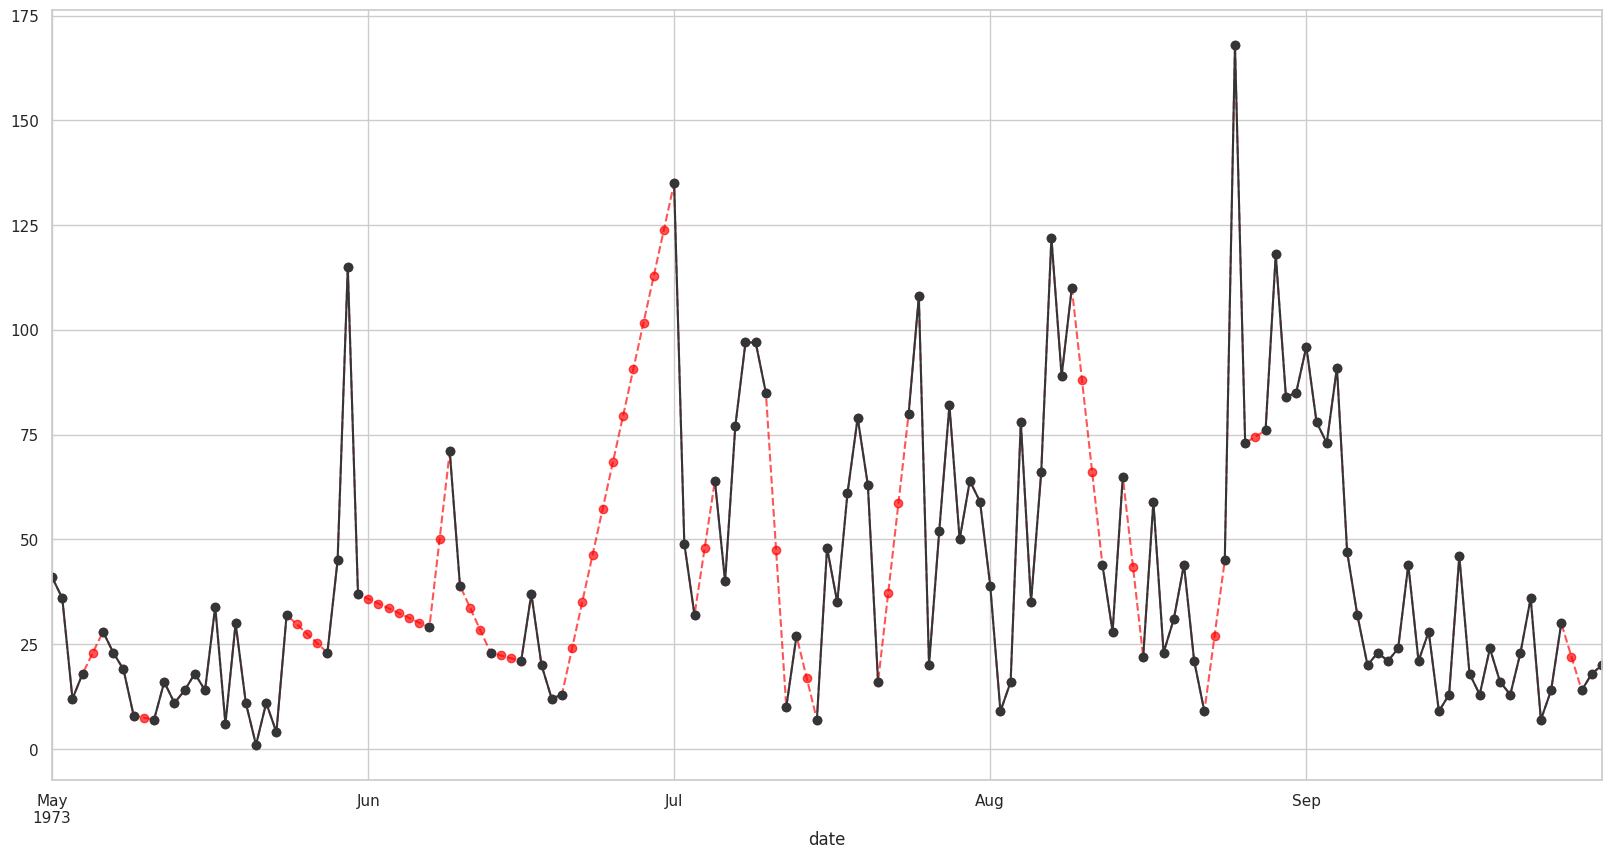

In [39]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='linear')
            .plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

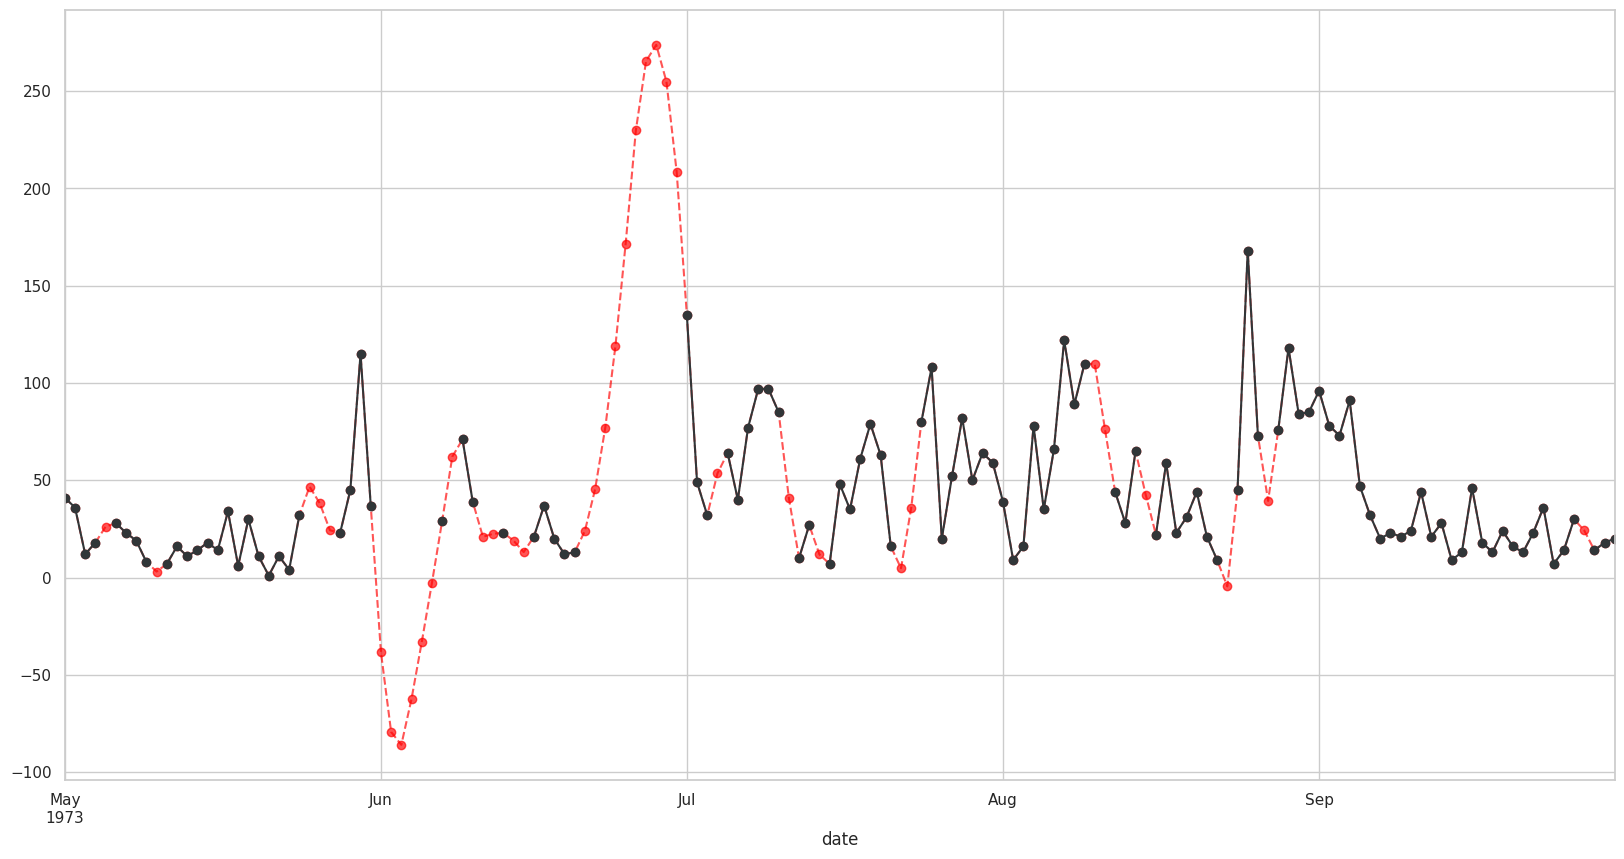

In [40]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='quadratic')
            .plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

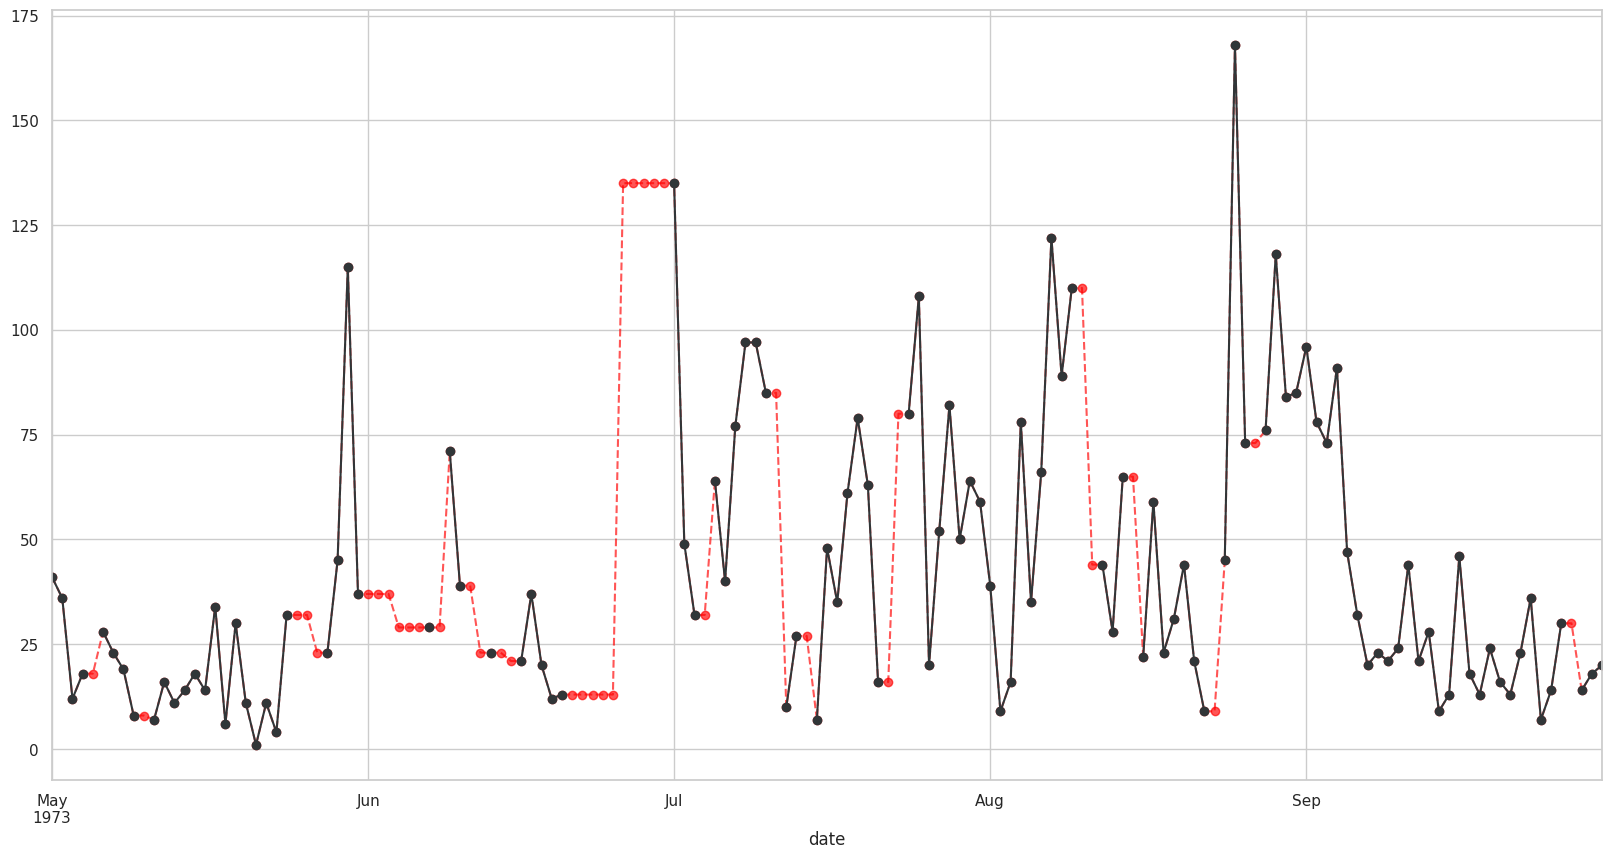

In [41]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='nearest')
            .plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

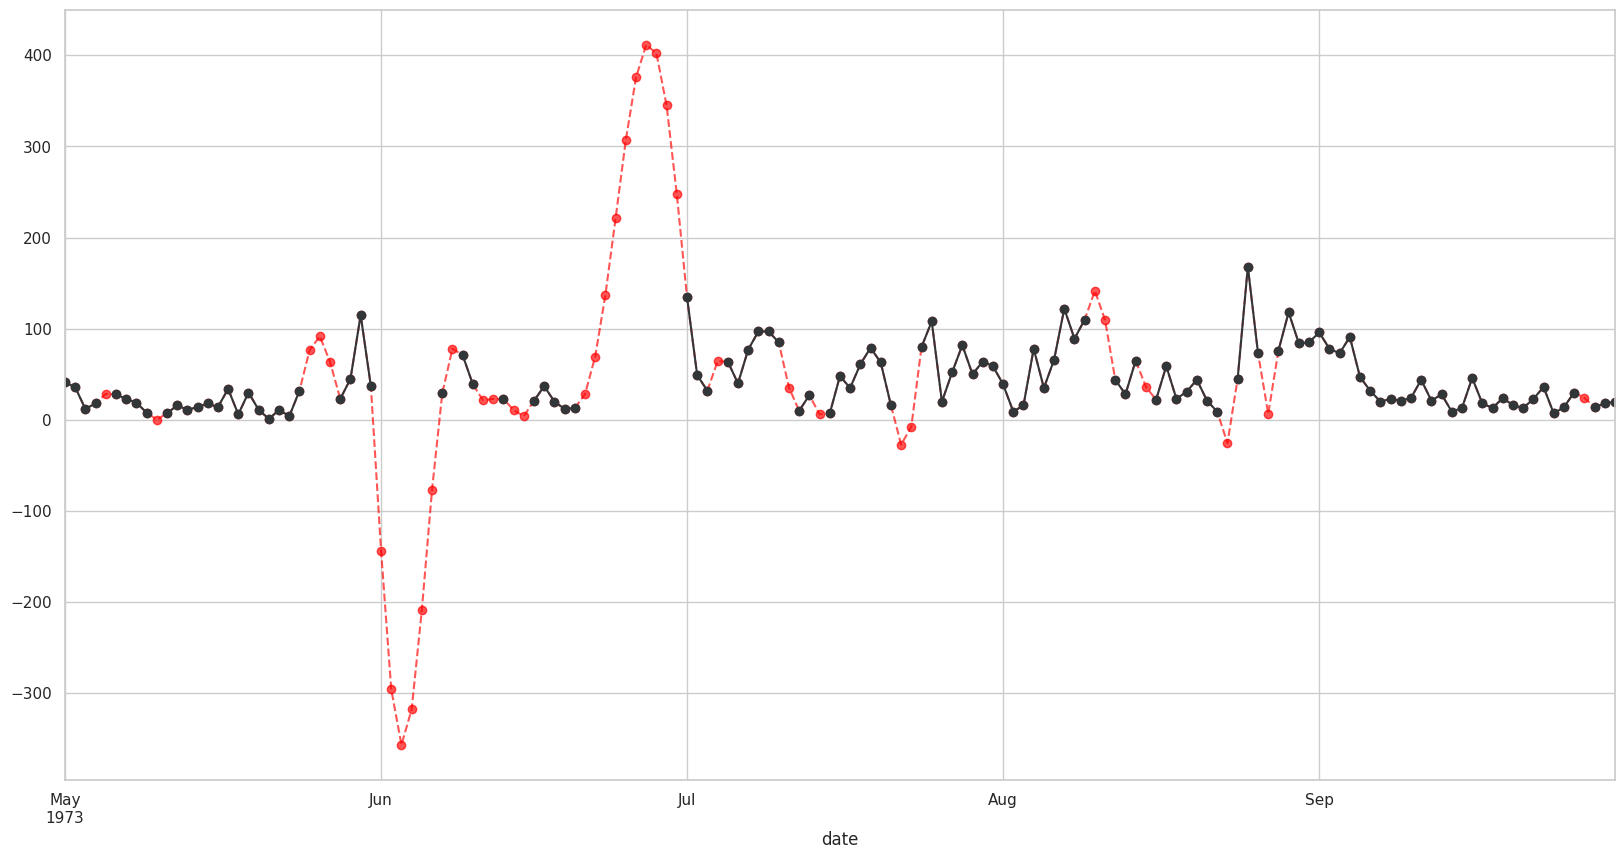

In [42]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns(
        ['ozone']
    )
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='polynomial',order=5)
            .plot(
                color='red',
                marker='o',
                alpha=6/9,
                linestyle='dashed'
                
                ),
            df.ozone.plot(
                color='#313638',
                marker= 'o'
                )
        )
    )
)
plt.show()

In [43]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='linear')
airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,23.0,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,22.0,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

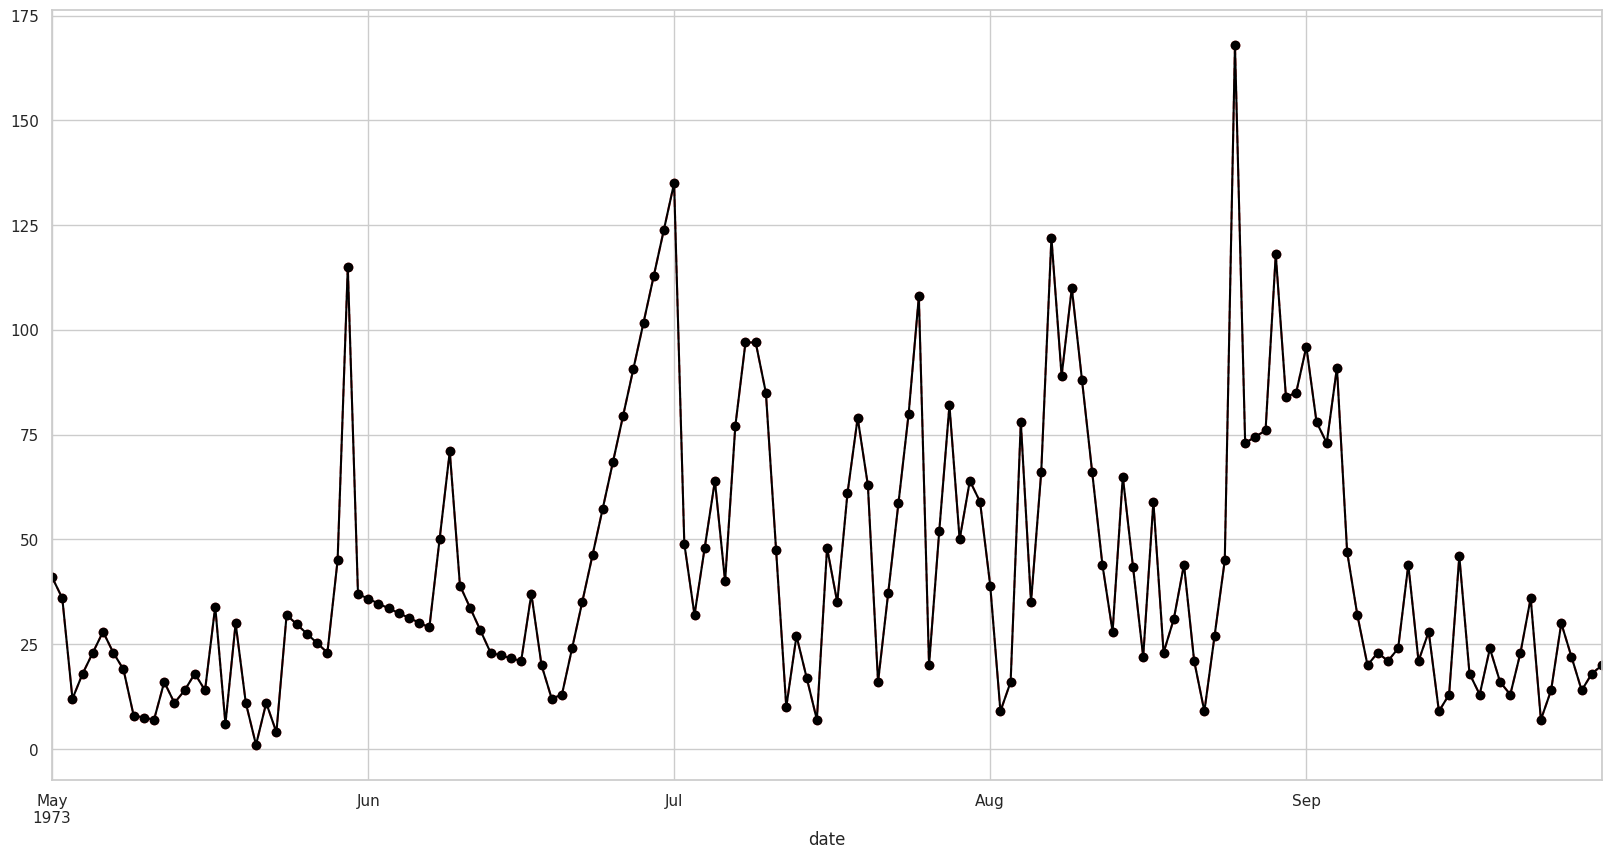

In [44]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .missing
    .interpolate_plot(
        column_name = 'ozone'
    )
)

## Imputación por algoritmo de vecinos más cercanos (KNN)

In [45]:
(
    nhanes_df
    .head()
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


In [46]:
(
    nhanes_transformed_df
    .head()
)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0


In [47]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()
nhanes_df_knn


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<Axes: xlabel='height', ylabel='weight'>

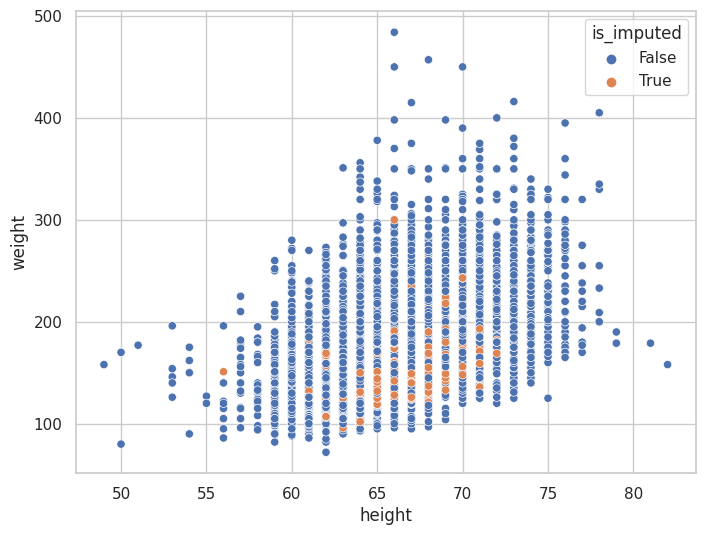

In [48]:
(
    pd.concat(
        [
        nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(true_string=True,false_string=False, suffix='_imp',only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
)

### Ordenamiento por cantidad de variables faltantes

In [49]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors=10)
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()
nhanes_df_knn

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,147.0,68.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0


<Axes: xlabel='height', ylabel='weight'>

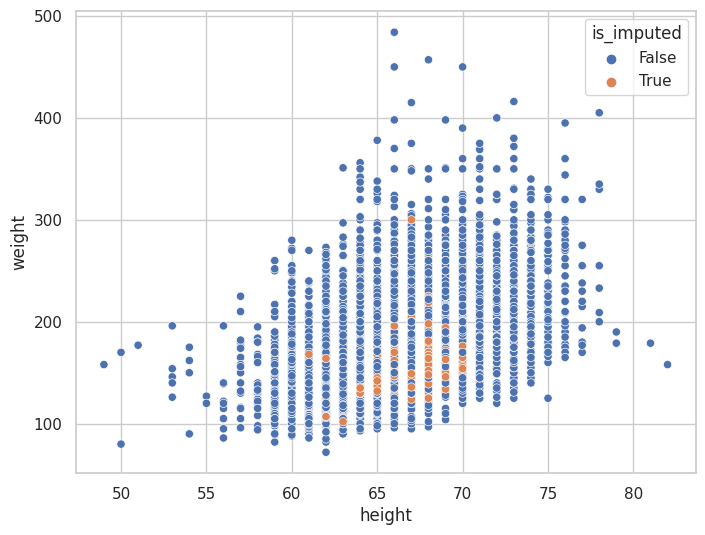

In [50]:
(
    pd.concat(
        [
        nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(true_string=True,false_string=False, suffix='_imp',only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
)


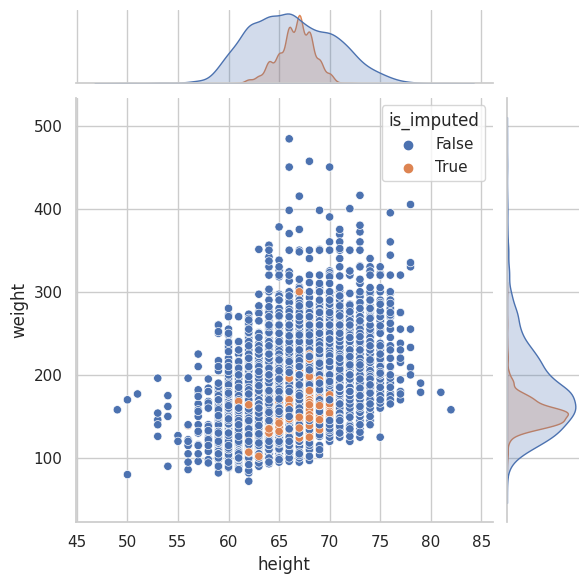

In [71]:
(
    pd.concat(
        [
        nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(true_string=True,false_string=False, suffix='_imp',only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal=True
    )
)

## Imputación basada en modelos

In [51]:
nhanes_model_df= (
    nhanes_df
    .select_columns(
        ['weight','height','gender','age']
    )
    .sort_values(
        by='height'
    )
    .transform_columns(
        ['weight'],
        lambda x:x.ffill(),
        elementwise= False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp'
    )
)

nhanes_model_df

,weight,height,gender,age,weight_imp,height_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,158.0,49.0,Female,80.0,False,False,False,False
96508.0,170.0,50.0,Female,46.0,False,False,False,False
97877.0,80.0,50.0,Female,29.0,False,False,False,False
102379.0,177.0,51.0,Female,71.0,False,False,False,False
93816.0,146.0,53.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,107.0,NaN,Female,14.0,False,True,False,False
102926.0,107.0,NaN,Female,15.0,False,True,False,False
102941.0,107.0,NaN,Female,14.0,False,True,False,False


In [52]:
height_ols=(
    nhanes_model_df
    .pipe(
        lambda df:smf.ols('height ~ weight + C(gender) + age', data=df))
    .fit()
)


In [53]:
ols_imputed_values=(
    nhanes_model_df
    .pipe(
        lambda df:df[df.height.isna()]
    )
    .pipe(
        lambda df:height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [54]:
nhanes_model_df.loc[nhanes_model_df.height.isna(),['height']] = ols_imputed_values

<Axes: xlabel='weight', ylabel='height'>

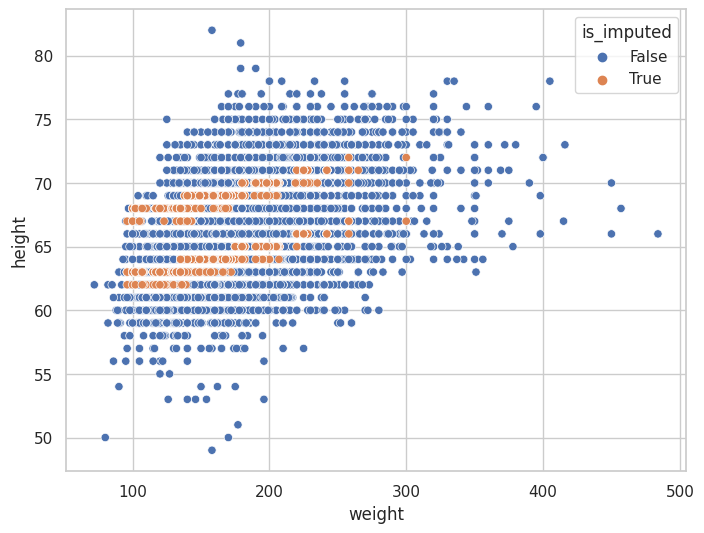

In [55]:
(
  nhanes_model_df
  .missing
  .scatter_imputation_plot(
      x='weight',
      y='height'
  )
)

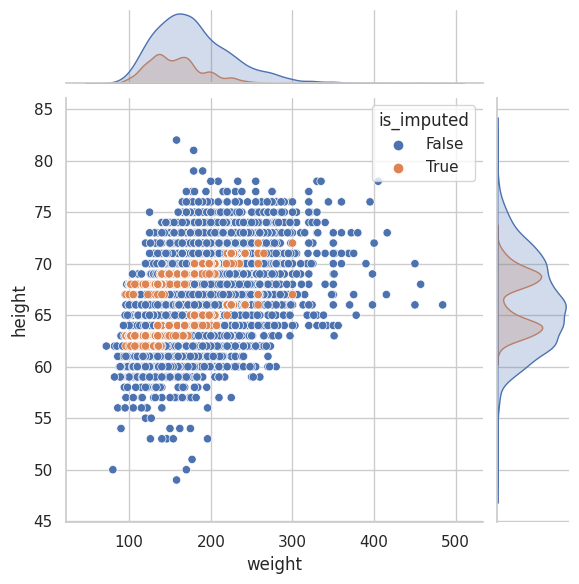

In [70]:
(
  nhanes_model_df
  .missing
  .scatter_imputation_plot(
      x='weight',
      y='height',
      show_marginal=True
  )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

In [66]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())
nhanes_mice_df = nhanes_transformed_df.copy(deep=True)
nhanes_mice_df.iloc[:,:]= mice_imputer.fit_transform(nhanes_mice_df).round()

nhanes_mice_df = pd.concat(
    [
    nhanes_mice_df,
    nhanes_df.missing.create_shadow_matrix(True,False,suffix='_imp')
    ],
    axis=1                          
)

nhanes_mice_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp,diabetes_imp,age_imp,gender_imp
SEQN,,,,,,,,,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False,False,False,False
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False,False,False,False
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False,False,False,False
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False,False,False,False
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False,False,False,False
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False,False,False,False
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False,False,False,False


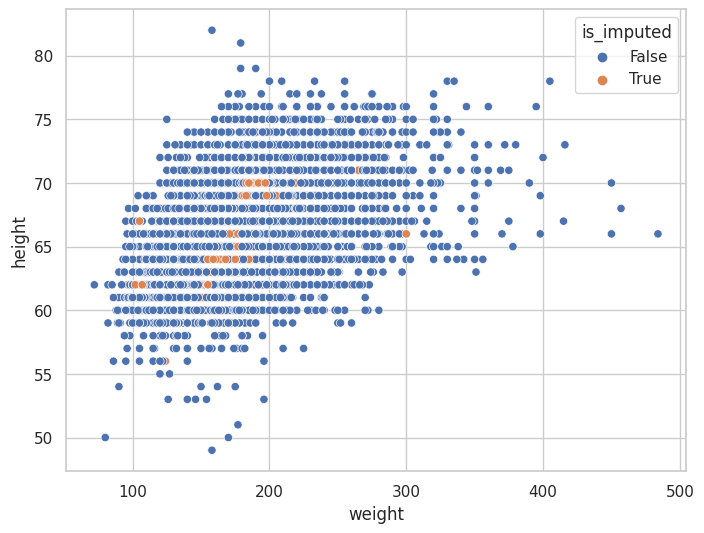

In [68]:
(
    nhanes_mice_df
    .missing
    .scatter_imputation_plot(
        x='weight',
        y='height'
    )
)
plt.show()

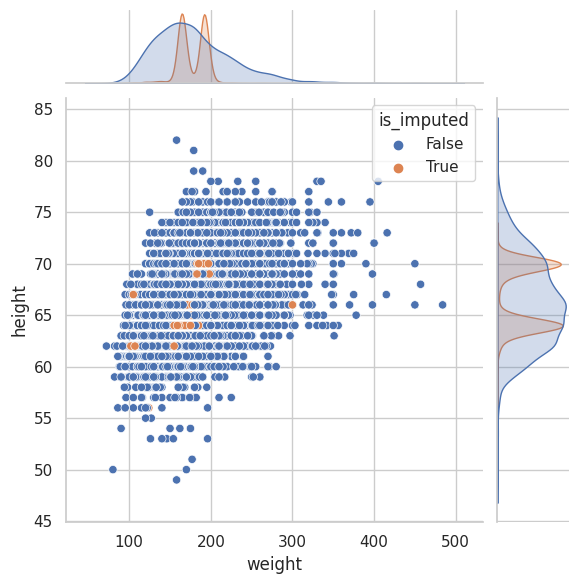

In [69]:
(
    nhanes_mice_df
    .missing
    .scatter_imputation_plot(
        x='weight',
        y='height',
        show_marginal=True
    )
)
plt.show()

## Transformación inversa de los datos

In [74]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

nhanes_imputed_df[categorical_columns]= (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X=nhanes_mice_df[categorical_columns]
    )
)
nhanes_imputed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp,diabetes_imp,age_imp,gender_imp
SEQN,,,,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False,False,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False,False,False,False


In [77]:
nhanes_df.general_health_condition.value_counts(dropna=False)

general_health_condition
Good         2383
Very good    1503
NaN          1360
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [79]:
nhanes_imputed_df.general_health_condition.value_counts(dropna=False)

general_health_condition
Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [81]:
nhanes_imputed_df2 = nhanes_df_knn.copy(deep=True)

nhanes_imputed_df2[categorical_columns]= (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X=nhanes_df_knn[categorical_columns]
    )
)
nhanes_imputed_df2

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,Female,0.0,66.0,52.0,157.0,Good,165.0,63.0
93706.0,Male,0.0,18.0,82.0,148.0,Very good,145.0,68.0
93707.0,Male,0.0,13.0,100.0,189.0,Good,147.0,68.0
93709.0,Female,0.0,75.0,74.0,176.0,Good,200.0,62.0
93711.0,Male,0.0,56.0,62.0,238.0,Very good,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,Male,0.0,33.0,96.0,201.0,Excellent,180.0,72.0
102953.0,Male,0.0,42.0,78.0,182.0,Fair or,218.0,65.0
102954.0,Female,0.0,41.0,78.0,172.0,Good,150.0,66.0


In [82]:
nhanes_imputed_df2.general_health_condition.value_counts()

general_health_condition
Good         3450
Very good    1503
Fair or      1205
Excellent     612
Poor?         387
Name: count, dtype: int64

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [56]:
session_info.show()

/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
/home/nico9779/anaconda3/envs/datos_imputados/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>